###This notebook contains some usual analysis for LPA
It only works for output format in pdb.

In [1]:
import numpy as np
import pylab as plt
from lpa_pdb_diagnostics import *
from scipy.constants import e, c, m_e, epsilon_0
import os
import matplotlib
%matplotlib inline

Result path /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/result/ is created


Setting the directory path where the data are located. dir_path has to be correctly attributed before analysis.

In [2]:
dir_path = os.getcwd() +"/data/"

Setting the path for the results:

In [3]:
res_path = config.result_path

#Laser - Plasma Parameters
Here we define some of the laser plasma parameters.

In [4]:
# Some definitions of the laser plasma parameters
lambda0 = 0.8e-6
w0 = 2*np.pi*c/lambda0
laser_waist = 17e-6
plasma_dens = 4e24
plasma_length = 4.5e-3
wp = np.sqrt(plasma_dens * e**2/ (epsilon_0 * m_e))
lambda_plasma = 2*np.pi*c/wp

#Numerical Parameters
Here we define the necessary numerical parameters for the analysis

In [5]:
zmax = 2*lambda0
zmin = zmax - 4*lambda_plasma
nzplambda = 20
w_size = zmax - zmin
Nz = int(w_size*nzplambda/lambda0)
dz = w_size/Nz

#Generate values for file reading

In [6]:
inf = 0
sup = 0
period_int = 1000
period_ext = 1000
val = values( inf, sup, period_int, period_ext, plasma_length/dz )
longitudinal_position = np.array(val)*dz

We create an array of file names that we analyze.

In [7]:
field = np.empty(len(val),dtype="S100")
N5 = np.empty(len(val),dtype="S100")
N6 = np.empty(len(val),dtype="S100")
N7 = np.empty(len(val),dtype="S100")
H = np.empty(len(val),dtype="S100")

# Initialize file names
for i, v in enumerate(val):
    field[i] = dir_path + "fields%06d.pdb" %v
    N5[i] = dir_path + "N5%06d.pdb" %v
    N6[i] = dir_path + "N6%06d.pdb" %v
    N7[i] = dir_path + "N7%06d.pdb" %v
    H[i] = dir_path + "H%06d.pdb" %v

#Reading files

##Multiple files reading

####Laser $a_0$, Beam spectrum, Big Picture

In [8]:
l_particle = False

#preparing some empty arrays
a0 = []
z_a0 = []
emitx = []
emity = []
deltaE = []
deltaEE = []
divx = []
divy = []
charge = []
ROI_peak = []
E_peak = []

last = len(val)
first  = 0#int(2.5e-3/dz/period_int) #round off to the nearest 1000

for index in range( first, last ):
    
    f = FieldInstant( field[index], np.pi/2, 
                 quantities= ["E", "zfield"] )
    a, z = f.laser_a0(w0)
    
    # Store values in arrays
    a0.append(a)
    z_a0.append(z)
    
    if l_particle:
        #p_H = ParticleInstant( H[index], quantities = [ "Weight", "Position", "Momentum"] )
        p_N6 = ParticleInstant( N6[index], quantities = [ "Weight", "Position", "Momentum"] )
        p_N7 = ParticleInstant( N7[index], quantities = [ "Weight", "Position", "Momentum"] )
        qdict = p_N6.get_qdict()
        
        #Select particles
        #cp_H = p_H.select( gamma_threshold = [50,800] )
        cp_N6 = p_N6.select( gamma_threshold = [50,800] )
        cp_N7 = p_N7.select( gamma_threshold = [50,800] )
        
        # Concatenate particles
        ck_all_particles = quant_concatenate([cp_N6,cp_N7], keep_object_name = True ) 
        #keeping the information on the species
        c_all_particles = quant_concatenate([cp_N6, cp_N7])
        
        # Analyzing beam spectrum
        energy, dQdE = beam_spectrum(val[index], 
                             ck_all_particles[qdict["gamma"]], 
                             ck_all_particles[qdict["w"]], lwrite=True,
                             leg = ["N6","N7","Sum"])
        
        if energy is not None:
            t_energy = energy[-1]
            t_dQdE = dQdE[-1]
            
            Ipeak, Epeak, Cpeak, ROI_by_peak = beam_peak( t_energy, t_dQdE)

            if Ipeak is not None:
                peak = (Ipeak[-1], Epeak[-1], Cpeak[-1])
                t_deltaE , t_deltaEE = beam_energy_spread( t_energy, t_dQdE, peak = peak)
            
            else:
                t_deltaE , t_deltaEE = beam_energy_spread( t_energy, t_dQdE )
            
            deltaE.append( t_deltaE )
            deltaEE.append( t_deltaEE )
            E_peak.append( Epeak )
        
        if energy is not None and ROI_by_peak:
            print "You have chosen particles situated between %g MeV and %g MeV. " \
                    %( ROI_by_peak[-1][0], ROI_by_peak[-1][1] )
    
            # Conversion from MeV to gamma arb units
            ROI_gamma = [[ROI_by_peak[i][j]/0.511 for j in xrange(len(ROI_by_peak[0]))] \
                         for i in xrange(len(ROI_by_peak))]
    
            # Selection of particles
            cPN6 = p_N6.select( gamma_threshold = ROI_gamma[-1] )
            cPN7 = p_N7.select( gamma_threshold = ROI_gamma[-1] )
            
            ck_all_particles = quant_concatenate([cPN6,cPN7], keep_object_name= True) 
            #keeping the information on the species
            c_all_particles = quant_concatenate([cPN6,cPN7])
            
            ROI_peak.append( ROI_gamma[-1] )
        
        # Analysing big picture
        N_laser = f.normalizedField( w0, "laser")
        N_wake = f.normalizedField( wp, "wake")
        bigPicture( val[index], c_all_particles[qdict["z"]], c_all_particles[qdict["gamma"]],
           c_all_particles[qdict["w"]], f.zfield, N_wake, N_laser, lwrite= True )
        
        
        # Analyzing beam emittance
        t_emitx = beam_emittance( val[index],  c_all_particles, qdict, "x" ) 
        t_emity = beam_emittance( val[index],  c_all_particles, qdict, "y" )
        
        # Store values in arrays
        emitx.append( t_emitx )
        emity.append( t_emity )
        
        # Analyzing beam divergence
        t_divx  = beam_divergence (c_all_particles, qdict, "x")
        t_divy  = beam_divergence (c_all_particles, qdict, "y")
        
        # Store values in arrays
        divx.append( t_divx )
        divy.append( t_divy )
        
        # Analyze beam charge
        t_charge = beam_charge(c_all_particles[qdict["w"]])
        
        # Store values in array
        charge.append( t_charge )

** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields001000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields002000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields003000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields004000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields005000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields006000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields007000.pdb **
** Processing ** Fields: Intialisation of /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/data/fields008000.pdb **
** Proce

##Saving laser $a_0$ values and beam properties in  in files.

In [9]:
qname = ["z", "a0" ]
f = FileWriting(qname, "a0")
stacked_data = np.stack(( z_a0, a0 ), axis=0)
f.write(stacked_data, np.shape(stacked_data), 
        attrs = ["m", "arb. unit" ])

A file named a0.hdf5 in /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/result/ is created.
** Writing is done **


In [10]:
if l_particle:
    qname = ["val", "deltaE", "deltaEE", "emitx", "emity", "divx", 
             "divy", "charge", "ROI_peak_left", "ROI_peak_right"]
    f = FileWriting(qname, "beam_properties_Nitrogen")
    stacked_data = np.stack(( longitudinal_position, deltaE, deltaEE, emitx, emity, 
                             divx, divy, charge, ROI_peak_left,  
                             ROI_peak_right), axis=0)
    f.write(stacked_data, np.shape(stacked_data), 
             attrs = [ "m", "MeV", "%", "m.rad", "m.rad", "rad", "rad", 
                      "C", "arb. units","arb. units"])

A file named beam_properties_Nitrogen.hdf5 in /Volumes/Orsay/gilles_Nitrogen/gilles_Nitrogen0.01_a01.4/result/ is created.


NameError: name 'long_pos' is not defined

##Plot $a_0$

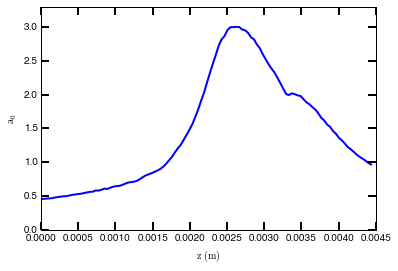

In [11]:
if 'inline' in matplotlib.get_backend():
    fig, ax = plt.subplots( dpi=150 )
else:
    fig, ax = plt.subplots( figsize=(10,8) )

fig.patch.set_facecolor('white')
ax.plot(z_a0, a0, linewidth = 2)

ax.set_xlabel(r"$\mathrm{z\,(m)}$")
ax.set_ylabel(r"$\mathrm{a_0}$")
ax.set_ylim(0.0, 1.1*max(a0))
ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

fig.savefig(res_path + "a0.pdf")